## Классификация текстов с использованием предобученных языковых моделей.

В данном задании вам предстоит обратиться к задаче классификации текстов и решить ее с использованием предобученной модели BERT.

In [1]:
import json
# do not change the code in the block below
# __________start of block__________
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from sklearn.base import BaseEstimator

%matplotlib inline
# __________end of block__________

Обратимся к набору данных SST-2. Holdout часть данных (которая понадобится вам для посылки) доступна по ссылке ниже.

In [2]:
# do not change the code in the block below
# __________start of block__________

!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/24f_yandex_ml_trainings/homeworks/hw04_bert_and_co/texts_holdout.json
# __________end of block__________

--2025-02-10 12:46:04--  https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/24f_yandex_ml_trainings/homeworks/hw04_bert_and_co/texts_holdout.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51581 (50K) [text/plain]
Saving to: ‘texts_holdout.json.1’

     0K .......... .......... .......... .......... .......... 99% 1.82M 0s
    50K                                                       100%  710G=0.03s

2025-02-10 12:46:04 (1.83 MB/s) - ‘texts_holdout.json.1’ saved [51581/51581]



In [3]:
# do not change the code in the block below
# __________start of block__________
df = pd.read_csv(
    "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv",
    delimiter="\t",
    header=None,
)
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]
with open("texts_holdout.json") as iofile:
    texts_holdout = json.load(iofile)
# __________end of block__________

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
%pip install transformers datasets evaluate accelerate

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


Весь остальной код предстоит написать вам.

Для успешной сдачи на максимальный балл необходимо добиться хотя бы __84.5% accuracy на тестовой части выборки__.

In [6]:
# your beautiful experiments here

from transformers import BertTokenizer, BertModel

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-02-10 12:46:10.308028: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 12:46:10.375827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-10 12:46:11.400987: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [8]:
def plot_train_process(
    train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=""
):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(" ".join(["Loss", title_suffix]))
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title(" ".join(["Validation accuracy", title_suffix]))
    axes[1].plot(train_accuracy, label="train")
    axes[1].plot(val_accuracy, label="validation")
    axes[1].legend()
    plt.show()


def visualize_and_save_results(
    model, model_name, X_train, X_test, y_train, y_test, out_dict
):
    for data_name, X, y, model in [
        ("train", X_train, y_train, model),
        ("test", X_test, y_test, model),
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(**(X.to(model.device))).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError("Unrecognized model type")

        auc = roc_auc_score(y, proba)

        out_dict[f"{model_name}_{data_name}"] = auc
        plt.plot(*roc_curve(y, proba)[:2], label="{} AUC={:.4f}".format(data_name, auc))

    plt.plot(
        [0, 1],
        [0, 1],
        "--",
        color="black",
    )
    plt.legend(fontsize="large")
    plt.title(model_name)
    plt.grid()
    return out_dict

In [14]:
class BertTextClassifier(torch.nn.Module):
    
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = BertModel.from_pretrained('bert-base-uncased')
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.dropout = torch.nn.Dropout(0.2).to(self.device)
        self.linear1 = torch.nn.Linear(768, 512).to(self.device)
        self.linear2 = torch.nn.Linear(512, 2).to(self.device)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, inputs):
        _, data = self.model(**inputs, return_dict=False)
        data = self.linear1(data)
        data = self.dropout(data)
        data = self.relu(data)
        data = self.linear2(data)
        return self.softmax(data)
    

In [15]:
model = BertTextClassifier()
print(model)

optim = torch.optim.Adam(model.parameters(), lr=4e-4)

loss_func = torch.nn.CrossEntropyLoss()

BertTextClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [16]:
def train_model(model, loss_fn, optim, y_train, y_val,
               batch_size=256, num_epochs=1000, eval_every=10, show_plot=True):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    local_train_loss_history = []
    local_train_acc_history = []
    X_val = tokenizer(texts_test.tolist(), return_tensors='pt', padding=True, truncation=True).to(model.device)
    
    for epoch in range(num_epochs):

        ix = np.random.randint(1, len(texts_train), batch_size)
        X_batch = tokenizer(texts_train[ix].tolist(), return_tensors='pt', padding=True, truncation=True).to(model.device)
        y_batch = torch.nn.functional.one_hot(y_train[ix]).to(torch.float32)

        outs = model(X_batch)
            
        preds = torch.argmax(outs, dim=1)
        loss = loss_fn(outs, y_batch)
        
        loss.backward()
        
        optim.step()
        
        optim.zero_grad()
            
        local_train_acc_history.append(
            accuracy_score(
                torch.argmax(y_batch, dim=1).to('cpu').detach().numpy(),
                preds.to('cpu').detach().numpy()
            )
        )
        local_train_loss_history.append(loss.item())
                
        if (epoch % eval_every == 0):
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []
            
            model.eval()
            with torch.no_grad():
                    
                outputs_val = model(X_val)

                preds_val = torch.argmax(outputs_val, dim=1)
                val_loss_history.append(loss_fn(outputs_val, y_val).item())
                
                val_acc_score = accuracy_score(
                    torch.argmax(y_val, dim=1).to('cpu').detach().numpy(),
                    preds_val.to('cpu').detach().numpy()
                )
                val_acc_history.append(val_acc_score)
            
            if show_plot:
                clear_output(wait=True)
                plot_train_process(
                    train_loss_history, val_loss_history, train_acc_history, val_acc_history
                )
    
    return model

In [17]:
y_train_torch = torch.tensor(y_train).to(model.device)
y_val_torch = torch.nn.functional.one_hot(torch.tensor(y_test)).to(torch.float32).to(model.device)

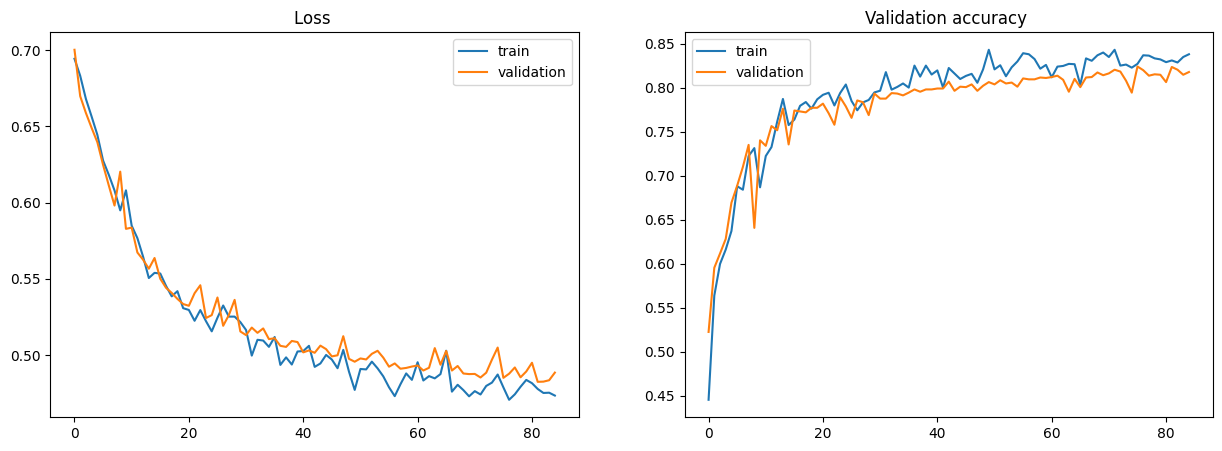

In [ ]:
ready_bert = train_model(model, loss_func, optim,
                         y_train_torch, y_val_torch)

#### Сдача задания в контест
Сохраните в словарь `out_dict` вероятности принадлежности к первому (положительному) классу

In [ ]:
X_val = tokenizer(texts_test.tolist(), return_tensors='pt', padding=True, truncation=True).to(model.device)
X_train = tokenizer(texts_train.tolist(), return_tensors='pt', padding=True, truncation=True).to(model.device)

In [ ]:
print(X_train)

In [ ]:
out_dict = {
    'train': [i[1] for i in model(X_train).to('cpu').detach().numpy().tolist()],
    'test': [i[1] for i in model(X_val).to('cpu').detach().numpy().tolist()],
    'holdout': [i[1] for i in model(tokenizer(texts_holdout, return_tensors='pt', padding=True, truncation=True).to(model.device)).to('cpu').detach().numpy().tolist()]
}

In [ ]:
print(len(out_dict['train']))

Несколько `assert`'ов для проверки вашей посылки:

In [ ]:
assert isinstance(out_dict["train"], list), "Object must be a list of floats"
assert isinstance(out_dict["train"][0], float), "Object must be a list of floats"
assert (
    len(out_dict["train"]) == 5000
), "The predicted probas list length does not match the train set size"

assert isinstance(out_dict["test"], list), "Object must be a list of floats"
assert isinstance(out_dict["test"][0], float), "Object must be a list of floats"
assert (
    len(out_dict["test"]) == 1920
), "The predicted probas list length does not match the test set size"

assert isinstance(out_dict["holdout"], list), "Object must be a list of floats"
assert isinstance(out_dict["holdout"][0], float), "Object must be a list of floats"
assert len(
    out_dict["holdout"] 
), "The predicted probas list length does not match the holdout set size"

Запустите код ниже для генерации посылки.

In [ ]:
# do not change the code in the block below
# __________start of block__________
FILENAME = "submission_dict_hw_text_classification_with_bert.json"

with open(FILENAME, "w") as iofile:
    json.dump(out_dict, iofile)
print(f"File saved to `{FILENAME}`")
# __________end of block__________

На этом задание завершено. Поздравляем!